<a href="https://colab.research.google.com/github/snaiws/NLP_project/blob/STS%2Futils/STS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Textual Similarity for Korean



## Import

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 74.8 MB/s 
     |████████████████████████████████| 6.6 MB 51.6 MB/s 
     |████████████████████████████████| 86 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 209 kB 54.5 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 146 kB 75.2 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 112 kB 63.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=4f41b146c39f6cbb1cef22f8a3da02396e101b86bdc05ed2be74c4dc6f1ebae9
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
!pip install hiddenlayer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import sys
import re
import pandas as pd
import numpy as np 
import copy
import time
import random
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,  RandomSampler, SequentialSampler, random_split
from torch.nn.utils import clip_grad_norm_

from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import transformers
from transformers import AdamW, get_scheduler

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, random_split
from transformers import BertTokenizer

from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import pearsonr

import optuna
import hiddenlayer

In [5]:
# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)


# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB
cuda


In [6]:
# seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [9]:
!git clone https://github.com/snaiws/NLP_project

fatal: destination path 'NLP_project' already exists and is not an empty directory.


In [10]:
cd /content/drive/MyDrive/NLP_project

/content/drive/MyDrive/NLP_project


### Model, Tokenizer

In [11]:
print(os.listdir('/content/drive/MyDrive/NLP_project/CustomModels'))

['BERT_baseline.py', 'BERT_seq.py', '__pycache__']


In [12]:
from CustomModels.BERT_baseline import Bert_baseline

In [13]:
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
#tokenizer = BertTokenizer.from_pretrained("klue/roberta-small")
#tokenizer = BertTokenizer.from_pretrained("klue/roberta-base")
#tokenizer = BertTokenizer.from_pretrained("klue/roberta-large")

customModel = Bert_baseline(hidden_size=768, n_label=6)

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Given data

In [14]:
# 파일 내 json 불러오기
df_train0 = pd.read_json('./data/klue-sts-v1.1_train.json')
df_test0 = pd.read_json('./data/klue-sts-v1.1_dev.json')

In [15]:
# shape
df_train0.shape, df_test0.shape

((11668, 6), (519, 6))

### Collected data

### target balence

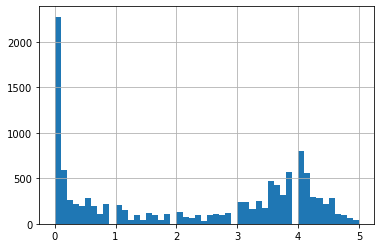

In [16]:
df_train0['labels'].map(lambda x: x['real-label']).hist(bins=50)

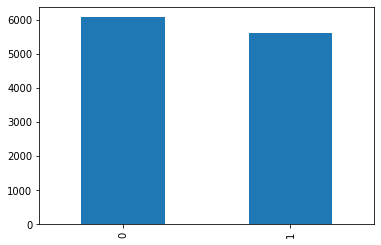

In [17]:
df_train0['labels'].map(lambda x: x['binary-label']).value_counts().plot(kind='bar')

### duplicates

In [18]:
#데이터 중복
df_train0[df_train0.duplicated(['sentence1','sentence2'],keep=False)==True]

,guid,source,sentence1,sentence2,labels,annotations
1514,klue-sts-v1_train_01514,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['0..."
1661,klue-sts-v1_train_01661,airbnb-rtt,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.","{'label': 4.7, 'real-label': 4.666666666666667...","{'agreement': '0:0:0:0:2:4', 'annotators': ['1..."
1715,klue-sts-v1_train_01715,airbnb-rtt,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.","{'label': 4.7, 'real-label': 4.666666666666667...","{'agreement': '0:0:0:0:2:4', 'annotators': ['1..."
3872,klue-sts-v1_train_03872,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1..."
5139,klue-sts-v1_train_05139,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.6, 'real-label': 4.571428571428571...","{'agreement': '0:0:0:0:3:4', 'annotators': ['0..."
5292,klue-sts-v1_train_05292,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['0..."
7045,klue-sts-v1_train_07045,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.0, 'real-label': 4.0, 'binary-labe...","{'agreement': '0:0:0:1:5:1', 'annotators': ['1..."
10908,klue-sts-v1_train_10908,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.0, 'real-label': 4.0, 'binary-labe...","{'agreement': '0:0:0:1:5:1', 'annotators': ['1..."
10939,klue-sts-v1_train_10939,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.6, 'real-label': 4.571428571428571...","{'agreement': '0:0:0:0:3:4', 'annotators': ['0..."
11112,klue-sts-v1_train_11112,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1..."


In [19]:
df_test0[df_test0.duplicated(['sentence1','sentence2'],keep=False)==True]

,guid,source,sentence1,sentence2,labels,annotations


In [20]:
pd.concat([df_train0.drop_duplicates(['sentence1','sentence2']),df_test0]).duplicated(['sentence1','sentence2']).sum()

0

In [21]:
df_train0.isna().sum().sum()+df_test0.isna().sum().sum()

0

## Data preprocess

### Preprocess

In [22]:
def check_st(text):
  text = re.sub(r"[^ㄱ-힣0-9\s]","",text)
  return text

def base_preprocess(train, test):
    train = train.drop_duplicates(['sentence1','sentence2']).reset_index(drop=True)
    s1 = train['sentence1'].map(lambda x: check_st(x))
    s2 = train['sentence2'].map(lambda x: check_st(x))
    real = train['labels'].map(lambda x: int(x['real-label']))
    binary = train['labels'].map(lambda x: int(x['binary-label']))
    train = pd.concat([s1,s2,real,binary],axis=1)
    train.columns = ['sentence1','sentence2','real','binary']
    train['sentence'] = train.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
    s1 = test['sentence1'].map(lambda x: check_st(x))
    s2 = test['sentence2'].map(lambda x: check_st(x))
    real = test['labels'].map(lambda x: int(x['real-label']))
    binary = test['labels'].map(lambda x: int(x['binary-label']))
    test = pd.concat([s1,s2,real,binary],axis=1)
    test.columns = ['sentence1','sentence2','real','binary']
    test['sentence'] = test.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
    return train, test

In [23]:
df_train, df_test = base_preprocess(df_train0,df_test0)

In [24]:
df_train.head()

,sentence1,sentence2,real,binary,sentence
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다,3,1,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다 [SEP] 숙박시설의 위치...
1,위반행위 조사 등을 거부방해기피한 자는 500만원 이하 과태료 부과 대상이다,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다,0,0,위반행위 조사 등을 거부방해기피한 자는 500만원 이하 과태료 부과 대상이다 [SE...
2,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,0,0,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘 [SEP] 사...
3,긴급 고용안정지원금은 지역고용대응 등 특별지원금 지자체별 소상공인 지원사업 취업성공...,고용보험이 1차 고용안전망이라면 국민취업지원제도는 2차 고용안전망입니다,0,0,긴급 고용안정지원금은 지역고용대응 등 특별지원금 지자체별 소상공인 지원사업 취업성공...
4,호스트의 답장이 늦으나 개선될 것으로 보입니다,호스트 응답이 늦었지만 개선될 것으로 보입니다,4,1,호스트의 답장이 늦으나 개선될 것으로 보입니다 [SEP] 호스트 응답이 늦었지만 개...


### Augmentation

### Token length

In [25]:
def tknz(text):
    x = tokenizer(
            text,
            add_special_tokens=True,
            truncation=True, # max_length를 넘는 문장은 이 후 토큰을 제거함
            max_length=512,
            return_tensors='pt' # 토크나이즈된 결과 값을 텐서 형태로 반환
        )
    return x

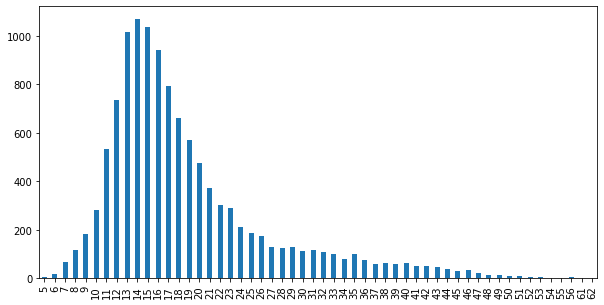

In [26]:
df_train['sentence1'].map(lambda x: tknz(x).input_ids.shape[1]).value_counts().sort_index().plot(kind='bar',figsize=(10,5))

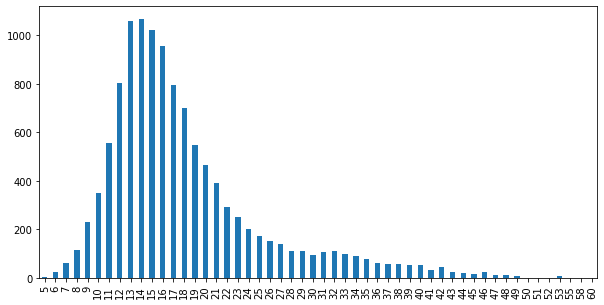

In [27]:
df_train['sentence2'].map(lambda x: tknz(x).input_ids.shape[1]).value_counts().sort_index().plot(kind='bar',figsize=(10,5))

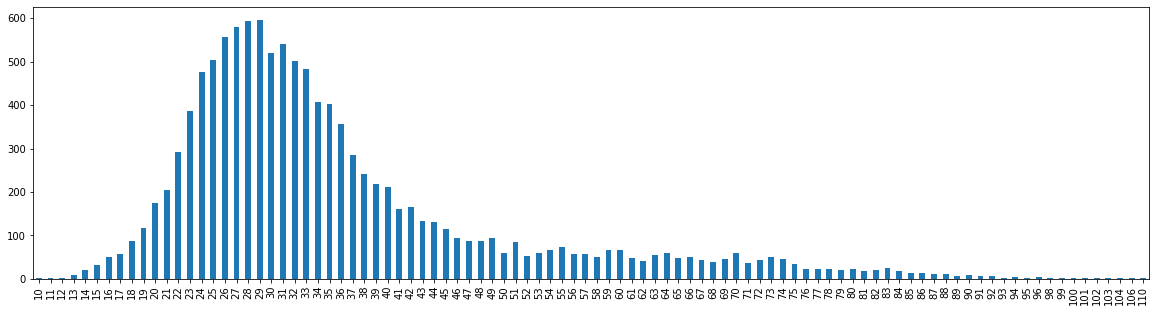

In [28]:
df_train['sentence'].map(lambda x: tknz(x).input_ids.shape[1]).value_counts().sort_index().plot(kind='bar',figsize=(20,5))

### Dataset

In [29]:
# Custom Dataset
class CustomDataset(Dataset):
    """
    - input_data: list of string
    - target_data: list of int
    """
    
    def __init__(self, input_data:list, target_data:list) -> None:
        self.X = input_data
        self.Y = target_data
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [30]:
train_dataset = CustomDataset(df_train.sentence.to_list(), df_train.real.to_list())
test_dataset = CustomDataset(df_test.sentence.to_list(), df_test.real.to_list())

### Split Data

In [31]:
n_sample = df_train.shape[0] # train 전체 길이
n_train = int(n_sample*0.9)
n_valid = n_sample-n_train
train_dataset, valid_dataset = random_split(train_dataset, [n_train, n_valid],generator=torch.Generator().manual_seed(seed))

In [32]:
print(f"Train Dataset len: {len(train_dataset)}")
print(f"Valid Dataset len: {len(valid_dataset)}")
print(f"Test Dataset len: {len(test_dataset)}")

Train Dataset len: 10494
Valid Dataset len: 1167
Test Dataset len: 519


## Utils

### Data Loader

In [33]:
# Custom collate_fn 
def BERT_base_collate_fn(batch):
    """
    한 배치 내 문장들을 tokenizing 한 후 텐서로 변환함. 
    이때, dynamic padding (즉, 같은 배치 내 토큰의 개수가 동일할 수 있도록, 부족한 문장에 [PAD] 토큰을 추가하는 작업)을 적용
    
    한 배치 내 레이블(target)은 텐서화 함.
    
    - batch: list of tuples (input_data(string), target_data(int))
    """
    input_list, target_list = [], []

    for _input, _target in batch:
        input_list.append(_input)
        target_list.append(_target)
    
    tensorized_input = tokenizer(
        input_list,
        add_special_tokens=True,
        padding="longest", # 배치내 가장 긴 문장을 기준으로 부족한 문장은 [PAD] 토큰을 추가
        truncation=True, # max_length를 넘는 문장은 이 후 토큰을 제거함
        max_length=512,
        return_tensors='pt' # 토크나이즈된 결과 값을 텐서 형태로 반환
    )
    
    tensorized_label = torch.tensor(target_list)
    
    return tensorized_input, tensorized_label

In [34]:
def init_data_loader(train_dataset,valid_dataset,test_dataset, train_batch_size, eval_batch_size):
    train_dataloader = DataLoader(
        train_dataset,
        batch_size = train_batch_size,
        sampler = RandomSampler(train_dataset,generator=torch.Generator().manual_seed(seed)),
        collate_fn = BERT_base_collate_fn
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size = eval_batch_size,
        sampler = SequentialSampler(valid_dataset),
        collate_fn = BERT_base_collate_fn
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size = eval_batch_size,
        sampler = SequentialSampler(test_dataset),
        collate_fn = BERT_base_collate_fn
    )
    print(f"Train dataloader # steps: {len(train_dataloader)}")
    print(f"Valid dataloader # steps: {len(valid_dataloader)}")
    print(f"Test dataloader # steps: {len(test_dataloader)}")
    return train_dataloader, valid_dataloader, test_dataloader

### Initializer

In [35]:
def initializer(model, train_dataloader, scheduler, warmup, lr, epochs, weight_decay):
    total_steps = len(train_dataloader) * epochs
    print(f"Total train steps with {epochs} epochs: {total_steps}")
    # initialize model 
    model = copy.deepcopy(model)
    # initilize optimizer 
    optimizer = AdamW(
        model.parameters(), # update 대상 파라미터를 입력
        lr=lr,
        eps=1e-8,
        weight_decay=weight_decay
    )
    # initilize scheduler
    scheduler = get_scheduler(
        scheduler,
        optimizer, 
        num_warmup_steps = warmup, 
        num_training_steps = total_steps
    )

    return model, optimizer, scheduler

### Early stopping

In [36]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=1, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = os.path.abspath(os.curdir)

    def __call__(self, val_loss, model, optimizer, scheduler, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
            self.counter = 0

    def save_checkpoint(self, model, optimizer, scheduler, epoch, loss):
        file_name = f'{self.path}/model.ckpt.best'
        
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss' : loss
            }, 
            file_name
        )
      
        print(f"Saving epoch {epoch} checkpoint at {file_name}")

### Train

In [37]:
def train_model(model, train_dataloader, valid_dataloader, optimizer, scheduler, threshold, epochs, loss_fct):
    # early_stopping object의 초기화
    early_stopping = EarlyStopping(patience = patience, verbose = True)
    vis2 = []
    # train_dataloaer 학습을 epochs만큼 반복
    for epoch in range(1, epochs + 1):
        print(f"*****Epoch {epoch} Train Start*****")
        
        # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
        total_loss, batch_loss, batch_count = 0,0,0

        # epoch마다 시각화
        vis1 = []

        # model을 train 모드로 설정 & device 할당
        model.train()
        model.to(device)
        
        # data iterator를 돌면서 하나씩 학습
        for step, batch in enumerate(train_dataloader):
            batch_count+=1
            
            # tensor 연산 전, 각 tensor에 device 할당
            batch = tuple(item.to(device) for item in batch)
        
            batch_input, batch_label = batch
        
            # batch마다 모델이 갖고 있는 기존 gradient를 초기화
            model.zero_grad()
        
            # forward
            logits = model(**batch_input)
            # loss
            loss = loss_fct(logits, batch_label)
            batch_loss += loss.item()
            total_loss += loss.item()

            # 시각화
            vis1.append([loss.item(), optimizer.param_groups[0]['lr']])

            # backward -> 파라미터의 미분(gradient)를 자동으로 계산
            loss.backward()
            
            # gradient clipping 적용 
            clip_grad_norm_(model.parameters(), threshold)
            
            # optimizer & scheduler 업데이트
            optimizer.step()
            scheduler.step()

            # 배치 10개씩 처리할 때마다 평균 loss와 lr를 출력
            if (step % 10 == 0 and step != 0):
                learning_rate = optimizer.param_groups[0]['lr']
                print(f"Epoch: {epoch}, Batch : {step}, LR : {learning_rate}, Avg Loss : {batch_loss / batch_count:.4f}")

                # reset 
                batch_loss, batch_count = 0,0
        
        print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
        print(f"*****Epoch {epoch} Train Finish*****\n")
        
        vis1 = pd.DataFrame(vis1,columns=['Train loss','Learning rate'])
        vis1.plot(kind='line',subplots=True, xlabel='batch',figsize=(20,10), title=f'epoch {epoch}')

        print(f"*****Epoch {epoch} Valid Start*****")
        valid_loss, valid_acc = validate(model, valid_dataloader, loss_fct)
        print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f} Valid Acc : {valid_acc:.2f}")
        print(f"*****Epoch {epoch} Valid Finish*****\n")

        vis2.append([total_loss/(step+1),valid_loss])

        # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
        #  만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        early_stopping(valid_loss, model, optimizer, scheduler, epoch)

        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    viz2 = pd.DataFrame(vis2,columns=['train loss','valid loss'])
    viz2.plot(kind='line', xlabel='epoch',figsize=(20,10))
            
    print("Train Completed. End Program.")

### Validate

In [38]:
def validate(model, valid_dataloader, loss_fct):
   
    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc= 0,0
        
    for step, batch in enumerate(valid_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
            
        # gradient 계산하지 않음
        with torch.no_grad():
            logits = model(**batch_input)
            
        # loss
        loss = loss_fct(logits, batch_label)
        total_loss += loss.item()
        
        # accuracy
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).flatten()
        acc = (preds == batch_label).cpu().numpy().mean()
        total_acc+=acc
    
    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)*100

    return total_loss, total_acc
    

## Train

In [39]:
# argument setting
train_batch_size = 32
eval_batch_size = 64
epochs = 25
patience = 2 # early stopping patience
lr = 2e-5 # learning rate
# scheduler 종류 : ['linear', 'cosine', 'cosine_with_restarts', 'polynomial', 'constant', 'constant_with_warmup']
scheduler_name = 'cosine'
warmup = 200 # scheduler의 warmup 단위는 batch = step
threshold = 1 # gradient clipping threshold
weight_decay = 0.01 # 0~0.1 logscale

loss_fct = nn.CrossEntropyLoss()

In [40]:
# reset gpu cache
gc.collect()
torch.cuda.empty_cache()

2022.6.11 16:55:9
Train dataloader # steps: 328
Valid dataloader # steps: 19
Test dataloader # steps: 9
Total train steps with 25 epochs: 8200


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


*****Epoch 1 Train Start*****
Epoch: 1, Batch : 10, LR : 1.1e-06, Avg Loss : 1.7916
Epoch: 1, Batch : 20, LR : 2.1000000000000002e-06, Avg Loss : 1.7916
Epoch: 1, Batch : 30, LR : 3.1000000000000004e-06, Avg Loss : 1.7617
Epoch: 1, Batch : 40, LR : 4.1e-06, Avg Loss : 1.7484
Epoch: 1, Batch : 50, LR : 5.1e-06, Avg Loss : 1.7068
Epoch: 1, Batch : 60, LR : 6.1e-06, Avg Loss : 1.6705
Epoch: 1, Batch : 70, LR : 7.100000000000001e-06, Avg Loss : 1.5967
Epoch: 1, Batch : 80, LR : 8.1e-06, Avg Loss : 1.4650
Epoch: 1, Batch : 90, LR : 9.100000000000001e-06, Avg Loss : 1.3601
Epoch: 1, Batch : 100, LR : 1.0100000000000002e-05, Avg Loss : 1.2212
Epoch: 1, Batch : 110, LR : 1.1100000000000002e-05, Avg Loss : 1.1016
Epoch: 1, Batch : 120, LR : 1.2100000000000001e-05, Avg Loss : 1.0159
Epoch: 1, Batch : 130, LR : 1.3100000000000002e-05, Avg Loss : 1.0506
Epoch: 1, Batch : 140, LR : 1.41e-05, Avg Loss : 1.0022
Epoch: 1, Batch : 150, LR : 1.5100000000000001e-05, Avg Loss : 1.0116
Epoch: 1, Batch : 16

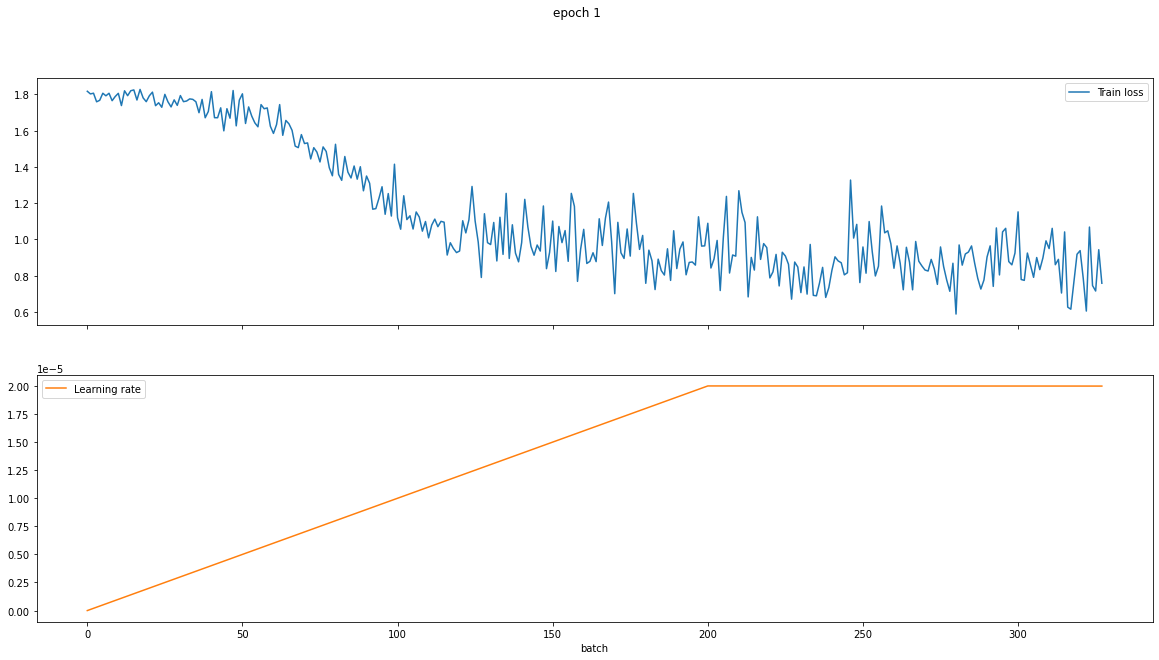

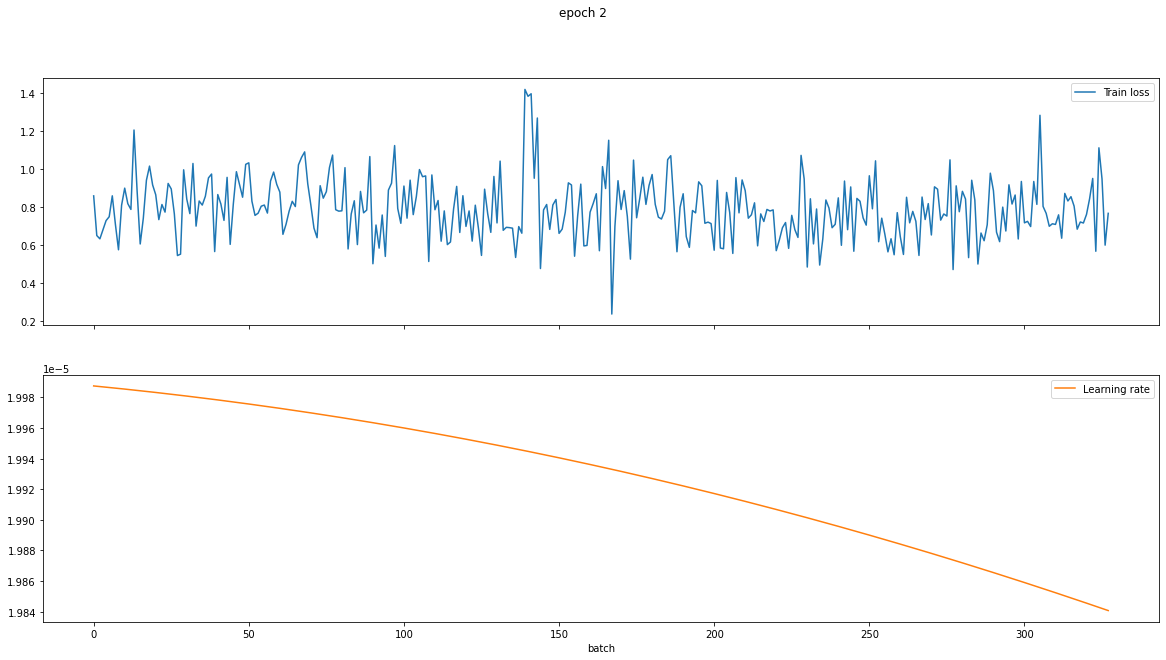

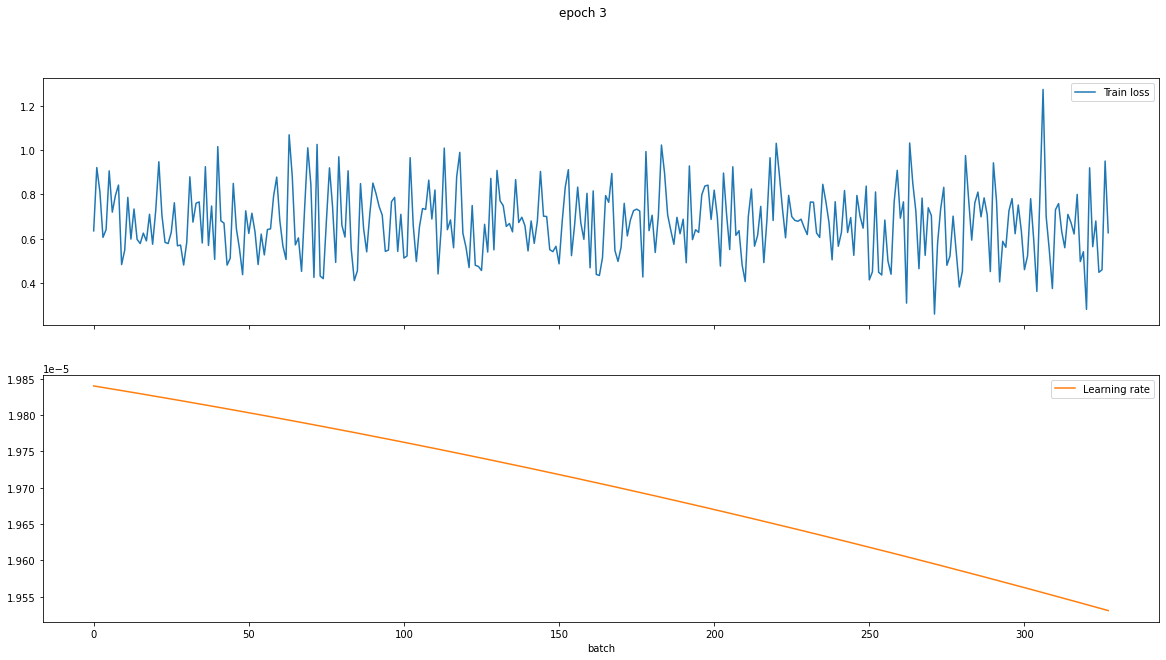

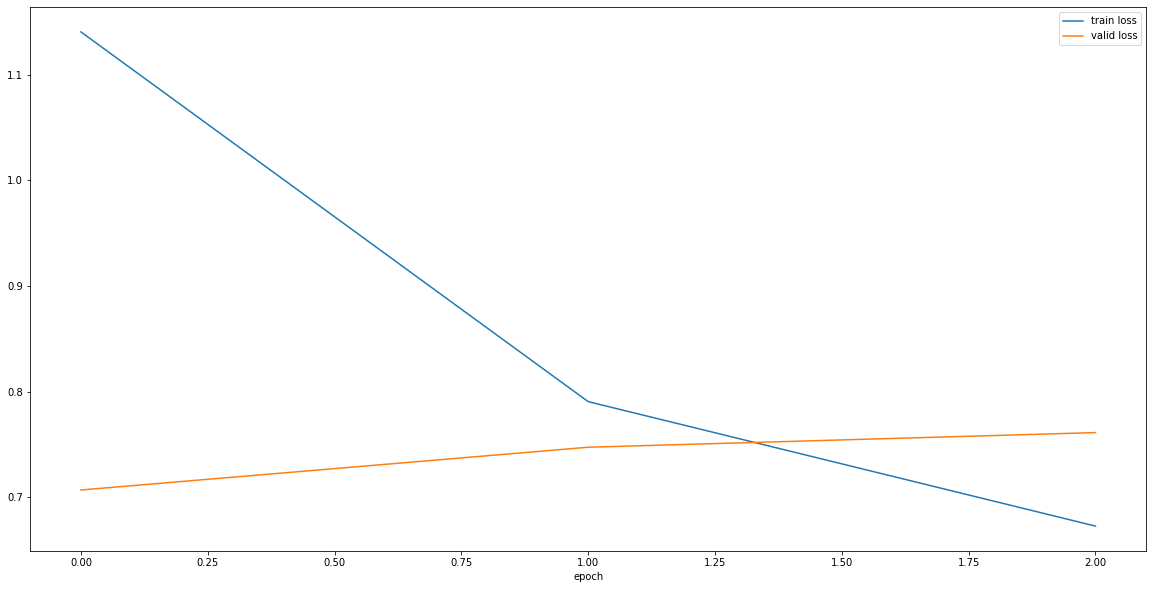

In [ ]:
# train
y, M, d, h, m, s, w, yd, isdst = time.gmtime()
current_time = f'{y}.{M}.{d} {h+9}:{m}:{s}'
print(current_time)
torch.cuda.manual_seed_all(seed)
train_dataloader, valid_dataloader, test_dataloader = init_data_loader(train_dataset,valid_dataset,test_dataset,train_batch_size,eval_batch_size)
model, optimizer, scheduler = initializer(customModel, train_dataloader, scheduler_name, warmup, lr, epochs, weight_decay)
train_model(model, train_dataloader, valid_dataloader, optimizer, scheduler, threshold, epochs, loss_fct)

## Evaluation

### Load checkpoint

In [ ]:
checkpoint = torch.load(f'./model.ckpt.best')

In [ ]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss'])

In [ ]:
epochs=1
model, optimizer, scheduler = initializer(customModel, train_dataloader, scheduler_name, warmup, lr, epochs, weight_decay)

Total train steps with 1 epochs: 328


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### predict and evaluate

In [ ]:
def predict(model, test_dataloader):
    """
    test_dataloader의 label별 확률값과 실제 label 값을 반환
    """

    model.eval()
    model.to(device)

    all_logits = []
    all_labels = []

    for step, batch in enumerate(test_dataloader):
        print(f"{step}/{len(test_dataloader)}")
        
        batch_input, batch_label = batch
        
        batch_input = batch_input.to(device)
        
        with torch.no_grad():
            logits = model(**batch_input)
            all_logits.append(logits)
        all_labels.extend(batch_label)

    all_logits = torch.cat(all_logits, dim=0)
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    all_labels = np.array(all_labels)

    return probs, all_labels


In [ ]:
probs, labels = predict(model, test_dataloader)

0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9


In [ ]:
pred = list(map(np.argmax,probs))

In [ ]:
def evaluate(pred, test):
    if len(set(pred))==2:
        pred_binary = pred
        test_binary_label = test
    else:
        pred_binary = list(map(lambda x: 1 if x>=3 else 0, pred))
        test_binary_label = list(map(lambda x: 1 if x>=3 else 0, test))
    print(f'acc : {accuracy_score(test_binary_label, pred_binary)}')
    print(f'f1 : {f1_score(test_binary_label, pred_binary)}')
    print(f'pearson : {pearsonr(test, pred)}')
    return f1_score(test_binary_label, pred_binary)
    

In [ ]:
evaluate(pred, labels)

acc : 0.7032755298651252
f1 : 0.7363013698630138
pearson : (0.7672541832850359, 8.418331252324357e-102)


0.7363013698630138

### Save outputs

In [ ]:
output = pd.DataFrame(labels,columns=['pred_real_label'])
filename = input()
output.to_csv(f'{filename}.csv')

BERT_seq


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

## Load model weights

In [ ]:
model = Bert_baseline(hidden_size=768, n_label=6)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
probs, labels = predict(model, test_dataloader)

0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9


In [ ]:
pred = list(map(np.argmax,probs))
evaluate(pred, labels)

acc : 0.7533718689788054
f1 : 0.7697841726618705
pearson : (0.7789983354145806, 7.071859924703616e-107)


## Hyperparameter tuning

In [ ]:
def optuna_train(model, train_dataloader, valid_dataloader, optimizer, scheduler, threshold, loss_fct):
    model.train()
    model.to(device)
    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(item.to(device) for item in batch)
        batch_input, batch_label = batch
        model.zero_grad()
        logits = model(**batch_input)
        loss = loss_fct(logits, batch_label)
        loss.backward()
        clip_grad_norm_(model.parameters(), threshold)
        optimizer.step()
        scheduler.step()


In [ ]:
def objective(trial):  # `trial` is an object passed by Optuna.
    train_batch_size = trial.suggest_int("train_batch_size",24,64)
    lr = trial.suggest_float("lr",1e-6,1e-4,log=True)
    warmup = trial.suggest_int("warmup",50,200,step=50) # scheduler의 warmup 단위는 batch = step
    weight_decay = trial.suggest_float("weight_decay",1e-3,1e-1,log=True)
    threshold = 1 # gradient clipping threshold
    epochs = 11
    # scheduler 종류 : ['linear', 'cosine', 'cosine_with_restarts', 'polynomial', 'constant', 'constant_with_warmup']
    scheduler_name = 'cosine'

    loss_fct = nn.CrossEntropyLoss()
    
    torch.cuda.manual_seed_all(seed)
    train_dataloader, valid_dataloader, test_dataloader = init_data_loader(train_dataset,valid_dataset,test_dataset,train_batch_size,eval_batch_size)
    model, optimizer, scheduler = initializer(customModel, train_dataloader, scheduler_name, warmup, lr, epochs, weight_decay)

    val_list = []
    for epoch in range(epochs):
        optuna_train(model, train_dataloader, valid_dataloader, optimizer, scheduler, threshold, loss_fct)
        valid_loss, valid_acc = validate(model, valid_dataloader, loss_fct)
        print(f'val_los : {valid_loss}')
        val_list.append(valid_loss)
        trial.report(valid_loss, step = epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return min(val_list)

In [ ]:
# optuna argument setting
eval_batch_size = 64
loss_fct = nn.CrossEntropyLoss()

In [ ]:
# reset gpu cache
gc.collect()
torch.cuda.empty_cache()

In [ ]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=seed),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, 
        max_resource=4, 
        reduction_factor=3
    ))
study.optimize(objective, n_trials=30)

[I 2022-06-11 08:48:49,379] A new study created in memory with name: no-name-16703361-4ef9-451e-8f9b-54a11de25cdc
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Train dataloader # steps: 270
Valid dataloader # steps: 19
Test dataloader # steps: 9
Total train steps with 11 epochs: 2970
val_los : 0.8439011479678907


KeyboardInterrupt: ignored

In [ ]:
print('Minimum objective value: ' + str(study.best_value))
print('Best parameter: ' + str(study.best_params))

ValueError: ignored

## Model visualization

In [ ]:
transforms = [
    # Fold repeated blocks
    #hiddenlayer.transforms.FoldDuplicates(),
]

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:324: UserWarning: Type cannot be inferred, which might cause exported graph to produce incorrect results.
  warnings.warn("Type cannot be inferred, which might cause exported graph to produce incorrect results.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:1672: UserWarning: Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "


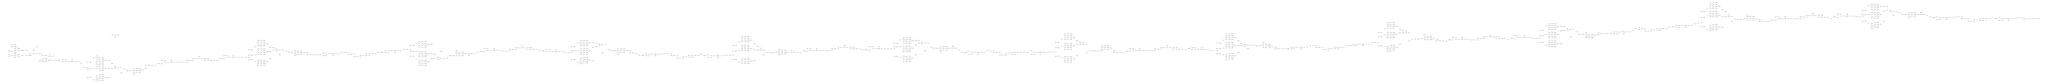

In [ ]:
hiddenlayer.build_graph(customModel, torch.zeros([1, 512], dtype = int, device = device), transforms = transforms)

In [42]:
a=customModel._modules

In [46]:
a.keys()

odict_keys(['bert', 'classifier'])

In [51]:
a['bert']._modules.keys()

odict_keys(['embeddings', 'encoder', 'pooler'])

In [141]:
a['bert']._modules['embeddings']._modules['word_embeddings']

Embedding(32000, 768, padding_idx=0)

In [55]:
a['bert']._modules['encoder']._modules.keys()

odict_keys(['layer'])

In [58]:
a['bert']._modules['encoder']._modules['layer']._modules.keys()

odict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])

In [117]:
a['bert']._modules['encoder']._modules['layer']._modules['0']._modules.keys()

odict_keys(['attention', 'intermediate', 'output'])

In [118]:
a['bert']._modules['encoder']._modules['layer']._modules['0']._modules

OrderedDict([('attention', BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output): BertSelfOutput(
                  (dense): Linear(in_features=768, out_features=768, bias=True)
                  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
              )), ('intermediate', BertIntermediate(
                (dense): Linear(in_features=768, out_features=3072, bias=True)
                (intermediate_act_fn): GELUActivation()
              )), ('output', BertOutput(
                (dense): Linear(in_features=3072, out_features=768, bias=True)
        

In [124]:
a['bert']._modules['encoder']._modules['layer']._modules['0']._modules['attention']._modules.keys()

odict_keys(['self', 'output'])

In [125]:
a['bert']._modules['encoder']._modules['layer']._modules['0']._modules['attention']._modules['self']._modules.keys()

odict_keys(['query', 'key', 'value', 'dropout'])

In [128]:
a['bert']._modules['encoder']._modules['layer']._modules['0']._modules['attention']._modules['self']._modules['query']

Linear(in_features=768, out_features=768, bias=True)

In [ ]:
class Haebu:
    def __init__(self, model):
        pass
    def soosool(self, ):
        pass

In [63]:
!pip install diagrams

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.8 MB 190 kB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


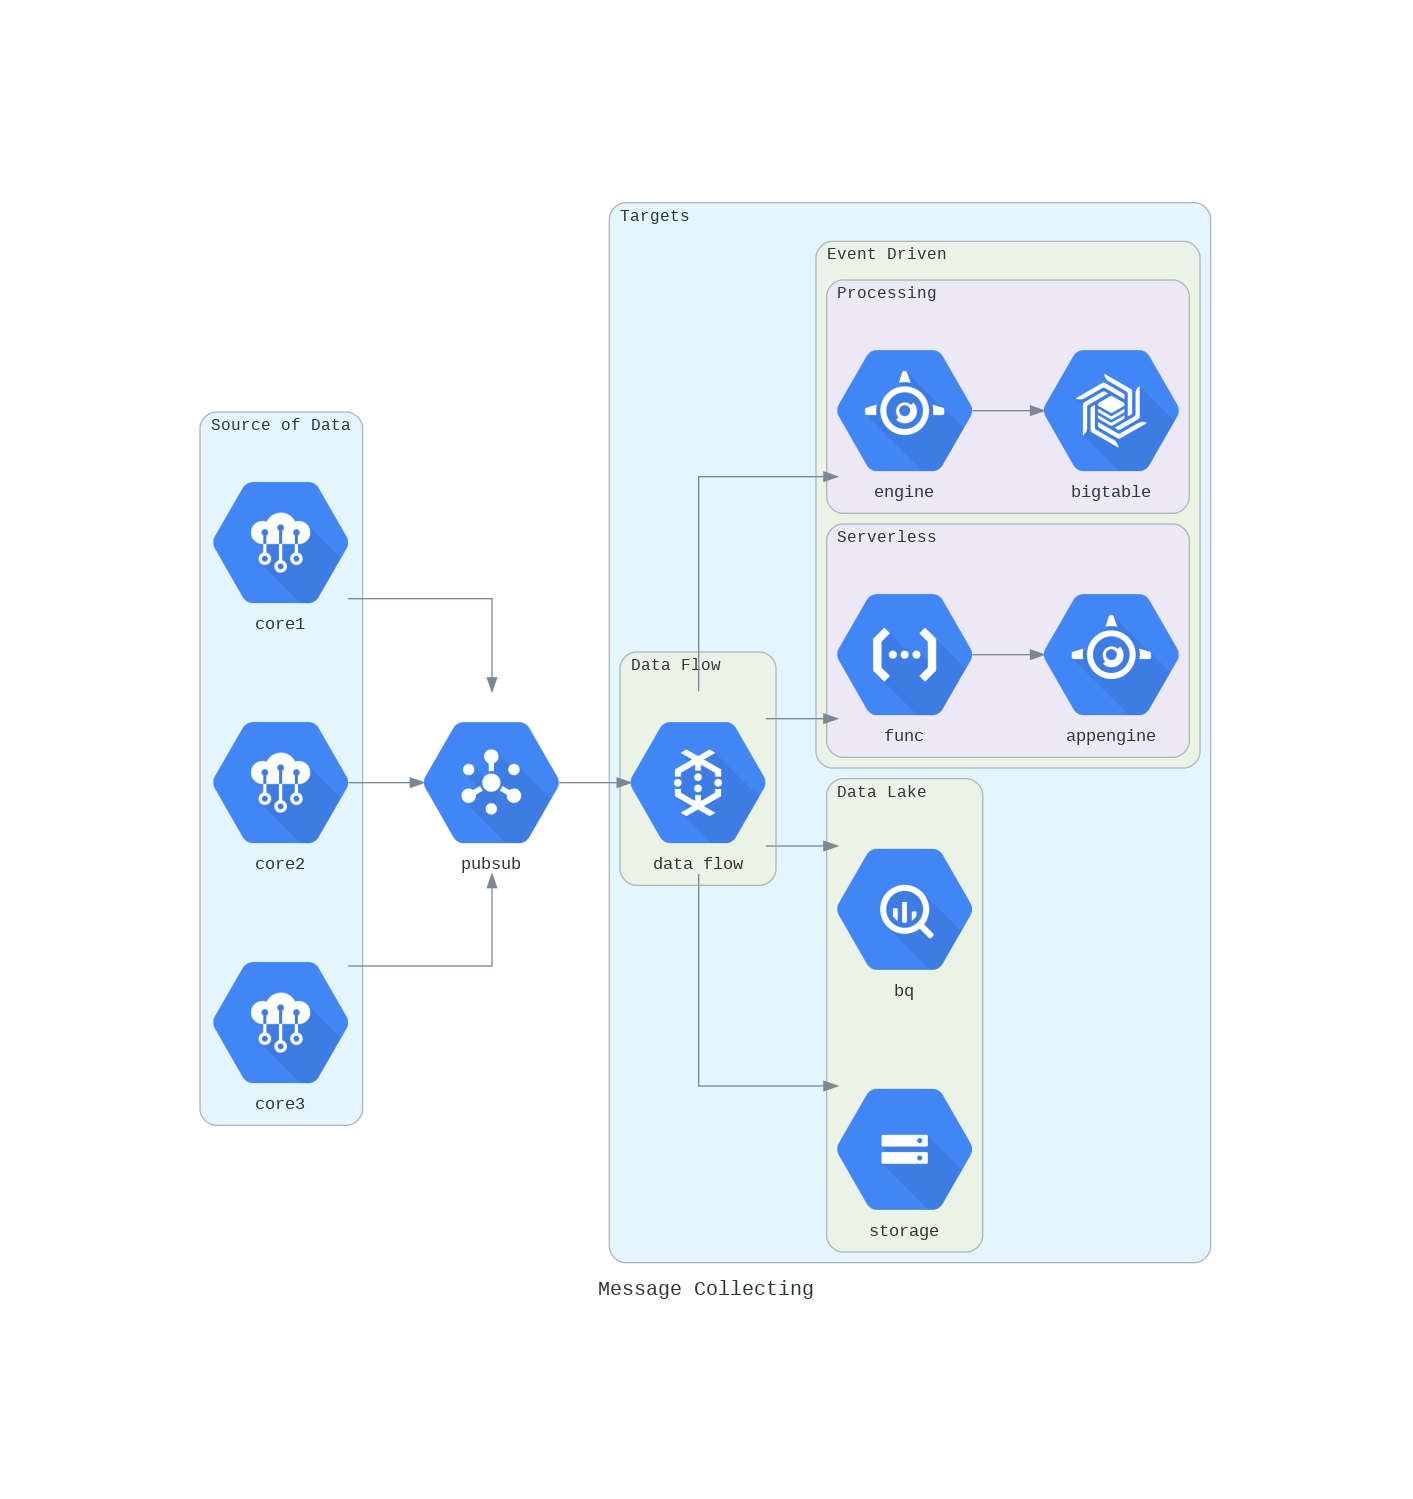

In [116]:
from diagrams import Cluster, Diagram
from diagrams.gcp.analytics import BigQuery, Dataflow, PubSub
from diagrams.gcp.compute import AppEngine, Functions
from diagrams.gcp.database import BigTable
from diagrams.gcp.iot import IotCore
from diagrams.gcp.storage import GCS

with Diagram("Message Collecting", show=False) as diag:
    pubsub = PubSub("pubsub")

    with Cluster("Source of Data"):
        [IotCore("core1"),
         IotCore("core2"),
         IotCore("core3")] >> pubsub

    with Cluster("Targets"):
        with Cluster("Data Flow"):
            flow = Dataflow("data flow")

        with Cluster("Data Lake"):
            flow >> [BigQuery("bq"),
                     GCS("storage")]

        with Cluster("Event Driven"):
            with Cluster("Processing"):
                flow >> AppEngine("engine") >> BigTable("bigtable")

            with Cluster("Serverless"):
                flow >> Functions("func") >> AppEngine("appengine")

    pubsub >> flow
display(diag)

In [129]:
train_dataloader, valid_dataloader, test_dataloader = init_data_loader(train_dataset,valid_dataset,test_dataset,train_batch_size,eval_batch_size)

Train dataloader # steps: 328
Valid dataloader # steps: 19
Test dataloader # steps: 9


In [131]:
for i,j in train_dataloader:
  b=i
  c=j
  break
b

{'input_ids': tensor([[    2,  6853,  2118,  ...,     0,     0,     0],
        [    2,  1363,  2075,  ...,     0,     0,     0],
        [    2,  1583,  2514,  ...,     0,     0,     0],
        ...,
        [    2,  1028,  3300,  ...,     0,     0,     0],
        [    2,  1388,  6233,  ...,     0,     0,     0],
        [    2,  8000, 16054,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [133]:
b['input_ids'].shape

torch.Size([32, 79])

In [134]:
b['token_type_ids'].shape

torch.Size([32, 79])

In [135]:
b['attention_mask'].shape

torch.Size([32, 79])

In [132]:
c

tensor([4, 3, 1, 3, 2, 2, 4, 0, 2, 0, 3, 0, 3, 4, 0, 4, 3, 4, 3, 0, 1, 4, 3, 2,
        0, 1, 4, 0, 0, 0, 0, 0])

In [163]:
from torchsummary import summary
summary(customModel,input_size=(1,124),dtypes=int)

TypeError: ignored

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from collections import OrderedDict
import numpy as np
def summary(model, input_size, batch_size=-1, device=torch.device('cuda:0'), dtypes=None):
    result, params_info = summary_string(
        model, input_size, batch_size, device, dtypes)
    print(result)

    return params_info
def summary_string(model, input_size, batch_size=-1, device=torch.device('cuda:0'), dtypes=None):
    if dtypes == None:
        dtypes = [torch.FloatTensor]*len(input_size)

    summary_str = ''
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
        ):
            hooks.append(module.register_forward_hook(hook))

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype).to(device=device)
         for in_size, dtype in zip(input_size, dtypes)]

    # create properties
    summary = OrderedDict()
    hooks = []

    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    summary_str += "----------------------------------------------------------------" + "\n"
    line_new = "{:>20}  {:>25} {:>15}".format(
        "Layer (type)", "Output Shape", "Param #")
    summary_str += line_new + "\n"
    summary_str += "================================================================" + "\n"
    total_params = 0
    total_output = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]

        total_output += np.prod(summary[layer]["output_shape"])
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        summary_str += line_new + "\n"

    # assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(sum(input_size, ()))
                           * batch_size * 4. / (1024 ** 2.))
    total_output_size = abs(2. * total_output * 4. /
                            (1024 ** 2.))  # x2 for gradients
    total_params_size = abs(total_params * 4. / (1024 ** 2.))
    total_size = total_params_size + total_output_size + total_input_size

    summary_str += "================================================================" + "\n"
    summary_str += "Total params: {0:,}".format(total_params) + "\n"
    summary_str += "Trainable params: {0:,}".format(trainable_params) + "\n"
    summary_str += "Non-trainable params: {0:,}".format(total_params -
                                                        trainable_params) + "\n"
    summary_str += "----------------------------------------------------------------" + "\n"
    summary_str += "Input size (MB): %0.2f" % total_input_size + "\n"
    summary_str += "Forward/backward pass size (MB): %0.2f" % total_output_size + "\n"
    summary_str += "Params size (MB): %0.2f" % total_params_size + "\n"
    summary_str += "Estimated Total Size (MB): %0.2f" % total_size + "\n"
    summary_str += "----------------------------------------------------------------" + "\n"
    # return summary
    return summary_str, (total_params, trainable_params)